In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [115]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<75000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
    df['outlier']=t
    
    return df

In [116]:
def categorizeNeighborhood(df):
    group = df.groupby("NEIGHBORHOOD")["SALE_PRICE"].mean().reset_index()
    group = group.rename(columns={"SALE_PRICE": "AVG_SALE_PRICE"})
    
    df = pd.merge(df, group, on="NEIGHBORHOOD", how="left")
    
    bins = [-np.inf, group["AVG_SALE_PRICE"].quantile(1/3), group["AVG_SALE_PRICE"].quantile(2/3), np.inf]
    n_cat = pd.cut(df["AVG_SALE_PRICE"], bins=bins, labels=[1,2,3])
    df = df.join(n_cat, rsuffix='_CATEGORY')
    return df

In [117]:
def markOutliersPerNieghborhood(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['lnprice'].quantile(0.25)
        q3 = g['lnprice'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        for i, r in g.iterrows():
            if r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0:
                t[i] = 1
    q1 = df['lnprice'].quantile(0.25)
    q3 = df['lnprice'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    for i, r in df.iterrows():
        if r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0:
            t[i] = 1
    df['outlier']=t
    return df

def checkUnits(df):
    t = np.zeros(df.shape[0])
    for i, r in df.iterrows():
        if r["RESIDENTIAL_UNITS"]==0 and r["COMMERCIAL_UNITS"]==0 and pd.isnull(r["TOTAL_UNITS"]):
            t[i]=1
        if r["LAND_SQUARE_FEET"]==0 and r["GROSS_SQUARE_FEET"]==0 and r["SALE_PRICE"]==0:
            t[i]=1
    df['no_units']=t
    return df   

def fillSquareFeet(df):
    dfCompleteGF=df.copy()
    dfCompleteLF=df.copy()
    dfCompleteGF['GROSS_SQUARE_FEET']=dfCompleteGF['GROSS_SQUARE_FEET'].replace(0,np.NaN)
    dfCompleteGF.dropna(inplace=True)
    dfCompleteLF['LAND_SQUARE_FEET']=dfCompleteGF['LAND_SQUARE_FEET'].replace(0,np.NaN)
    dfCompleteLF.dropna(inplace=True)
    groupedGF=dfCompleteGF.groupby("NEIGHBORHOOD")["GROSS_SQUARE_FEET"].mean()
    groupedLF=dfCompleteLF.groupby("NEIGHBORHOOD")["LAND_SQUARE_FEET"].mean()
    lf_dict={}
    gf_dict={}
    for n, g in groupedGF.iteritems():
        gf_dict[n]=g
    for n, g in groupedLF.iteritems():
        lf_dict[n]=g

    for i,r in df.iterrows():
        if pd.isnull(r['LAND_SQUARE_FEET']):
            df.loc[i, 'LAND_SQUARE_FEET']=lf_dict[r['NEIGHBORHOOD']]
        if pd.isnull(r['GROSS_SQUARE_FEET']):
            df.loc[i, 'GROSS_SQUARE_FEET']=gf_dict[r['NEIGHBORHOOD']]
    
    return df


In [118]:
def step1_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')

    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)

    #df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]]=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0, np.NaN)

    df["YEAR_BUILT"]=df["YEAR_BUILT"].replace(0, np.NaN)
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #df['lnprice']=np.log(df["SALE_PRICE"])
    df=checkUnits(df)
    df=df[df.no_units==0]
    df=df.drop('no_units', axis=1)
    df.reset_index(drop=True, inplace=True)
    #df.drop('lnprice',axis=1)
    df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]]=df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].replace(0, np.NaN)
    df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]] = df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].interpolate(method="polynomial", order=3)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['lnprice']=np.log(df["SALE_PRICE"])
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df=categorizeNeighborhood(df)
    
    print(df.shape)

    return df

In [119]:
def normalize(df,num_cols):
    df_norm=df.copy()
    df_norm[num_cols]=df_norm[num_cols]/df_norm[num_cols].abs().max()
    return df_norm

In [120]:
df = step1_clean()
df.reset_index(drop=True,inplace=True)
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

print(df.shape)
dfnorm=normalize(df, numerical)
df.drop(columns=['SALE_PRICE',], inplace=True)
# dfnorm.drop(columns=['SALE_PRICE',], inplace=True)
# numerical.remove("SALE_PRICE")


(27395, 21)


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\zacha\AppData\Local\Programs\Pyth

(14061, 21)
(14061, 21)


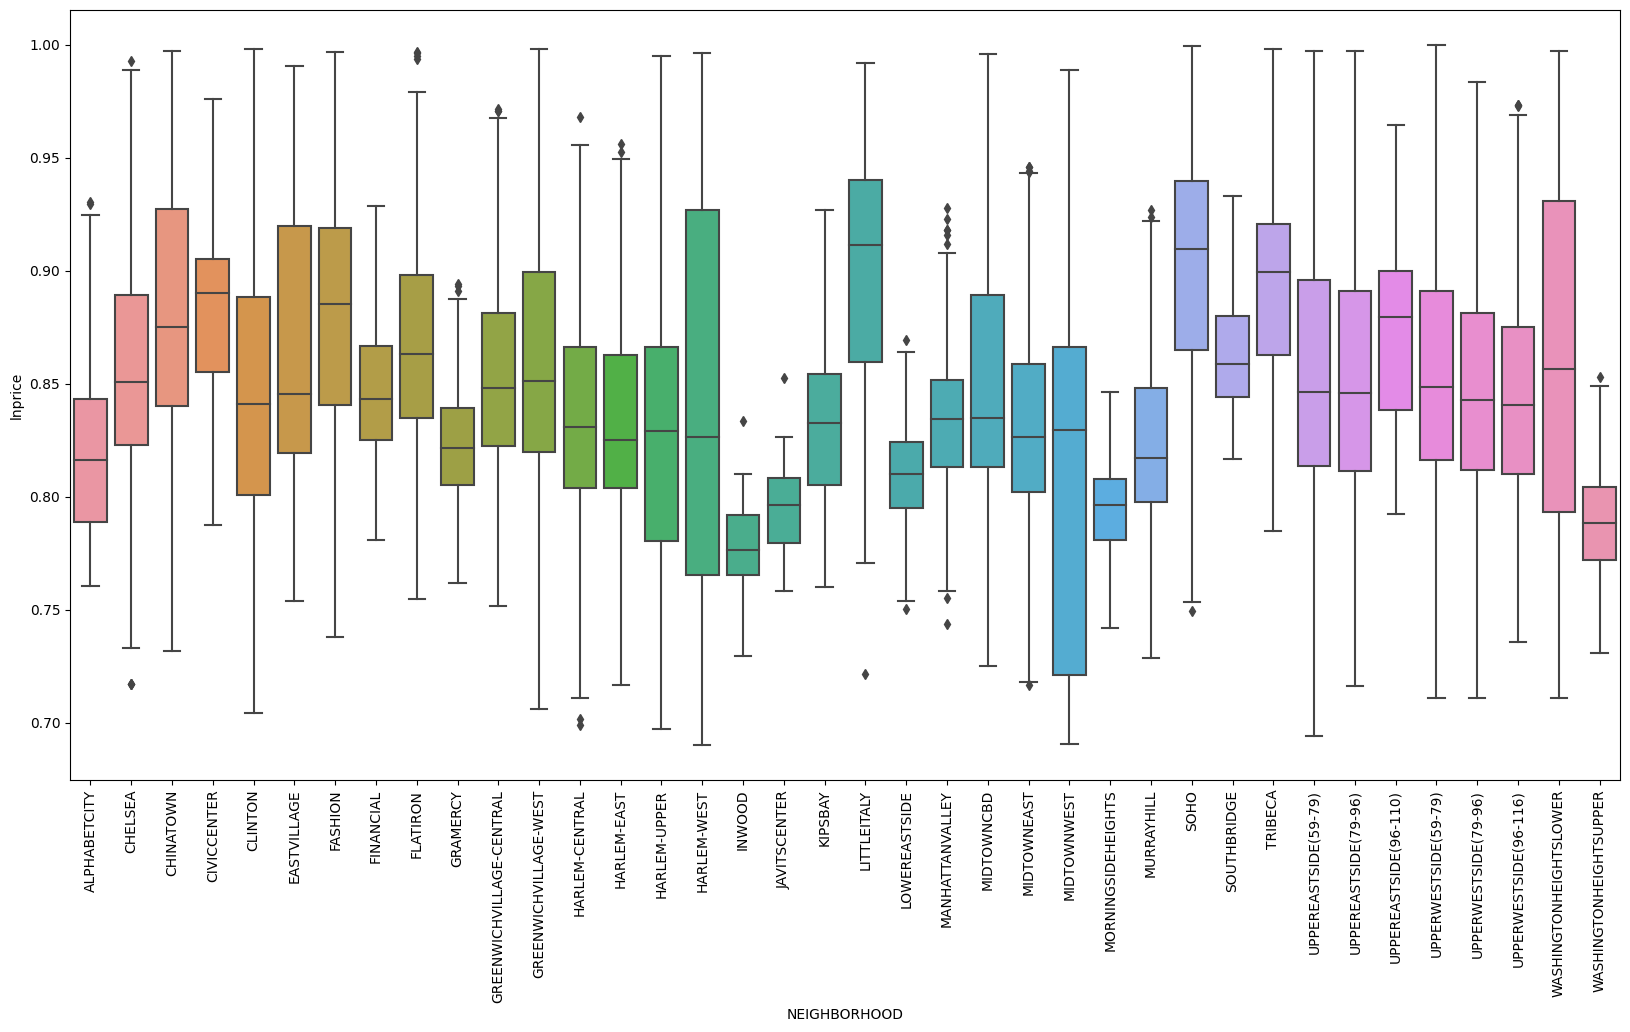

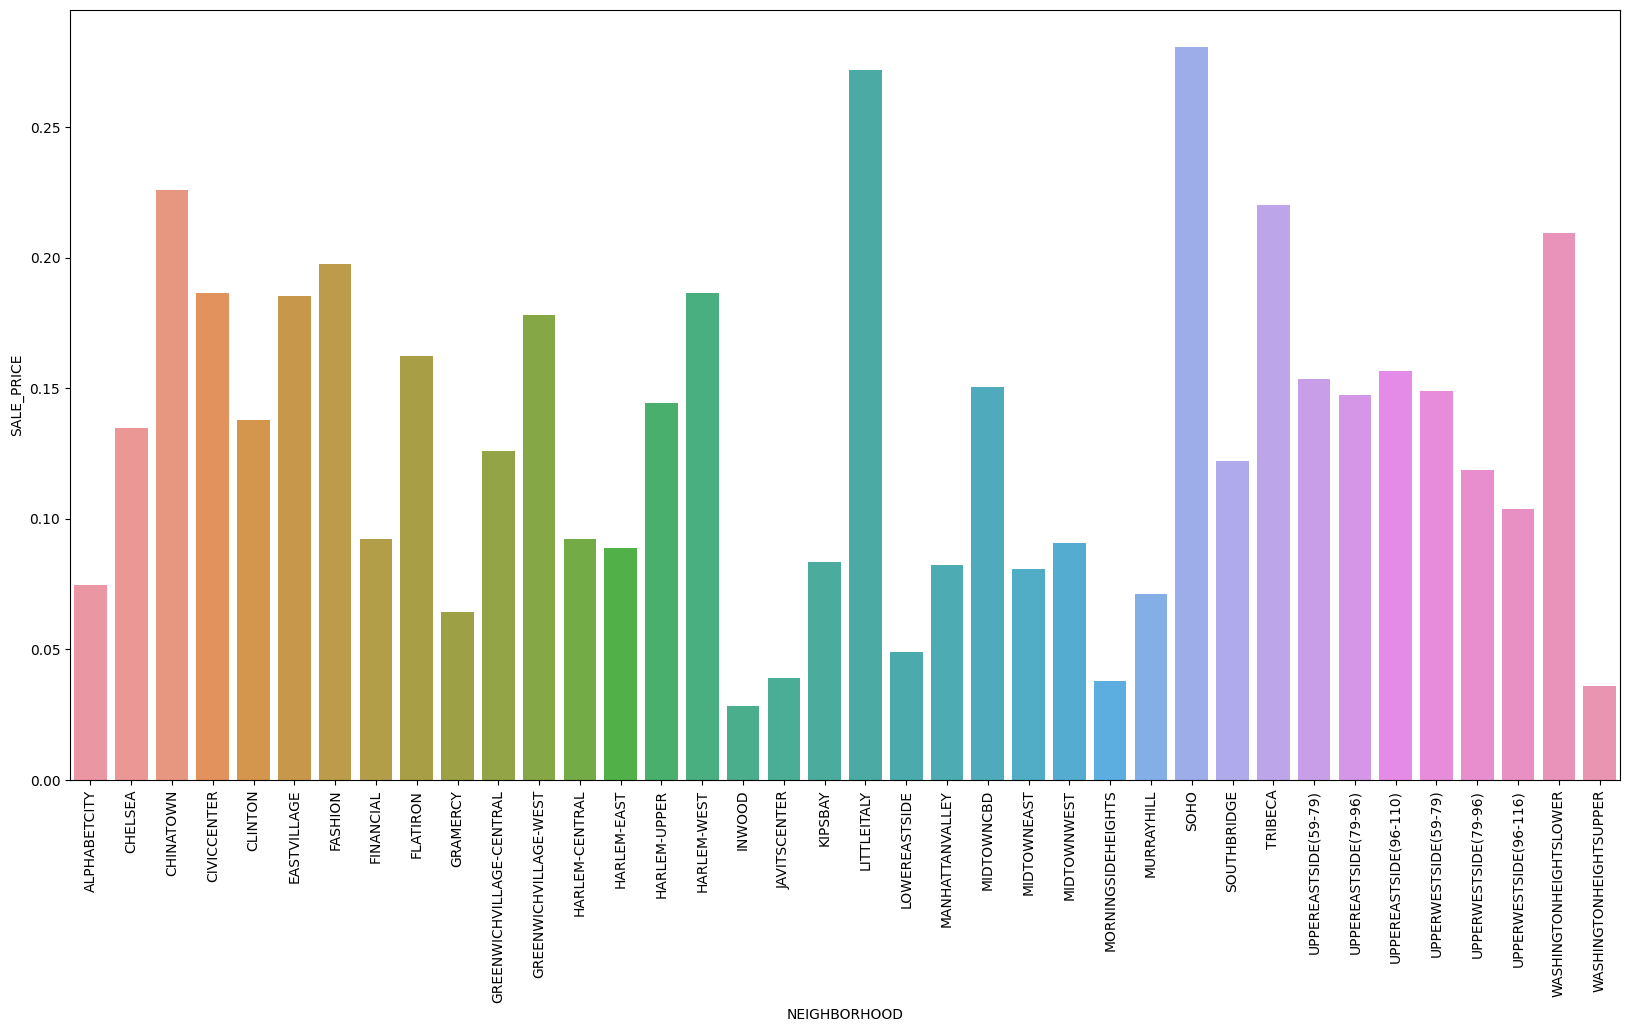

In [111]:
def boxPlot(df, y, x):
    plt.figure(figsize=[20,10])
    sns.boxplot( y=df[y], x=df[x] )
    plt.xticks(rotation=90)
    plt.show()

def averagePrice(df, y, x):
    plt.figure(figsize=[20,10])
    data=dfnorm.groupby(x)[y].mean().reset_index()
    sns.barplot(x=x,y=y, data=data)
    plt.xticks(rotation=90)
    plt.show()
boxPlot(dfnorm, 'lnprice', 'NEIGHBORHOOD')
averagePrice(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')

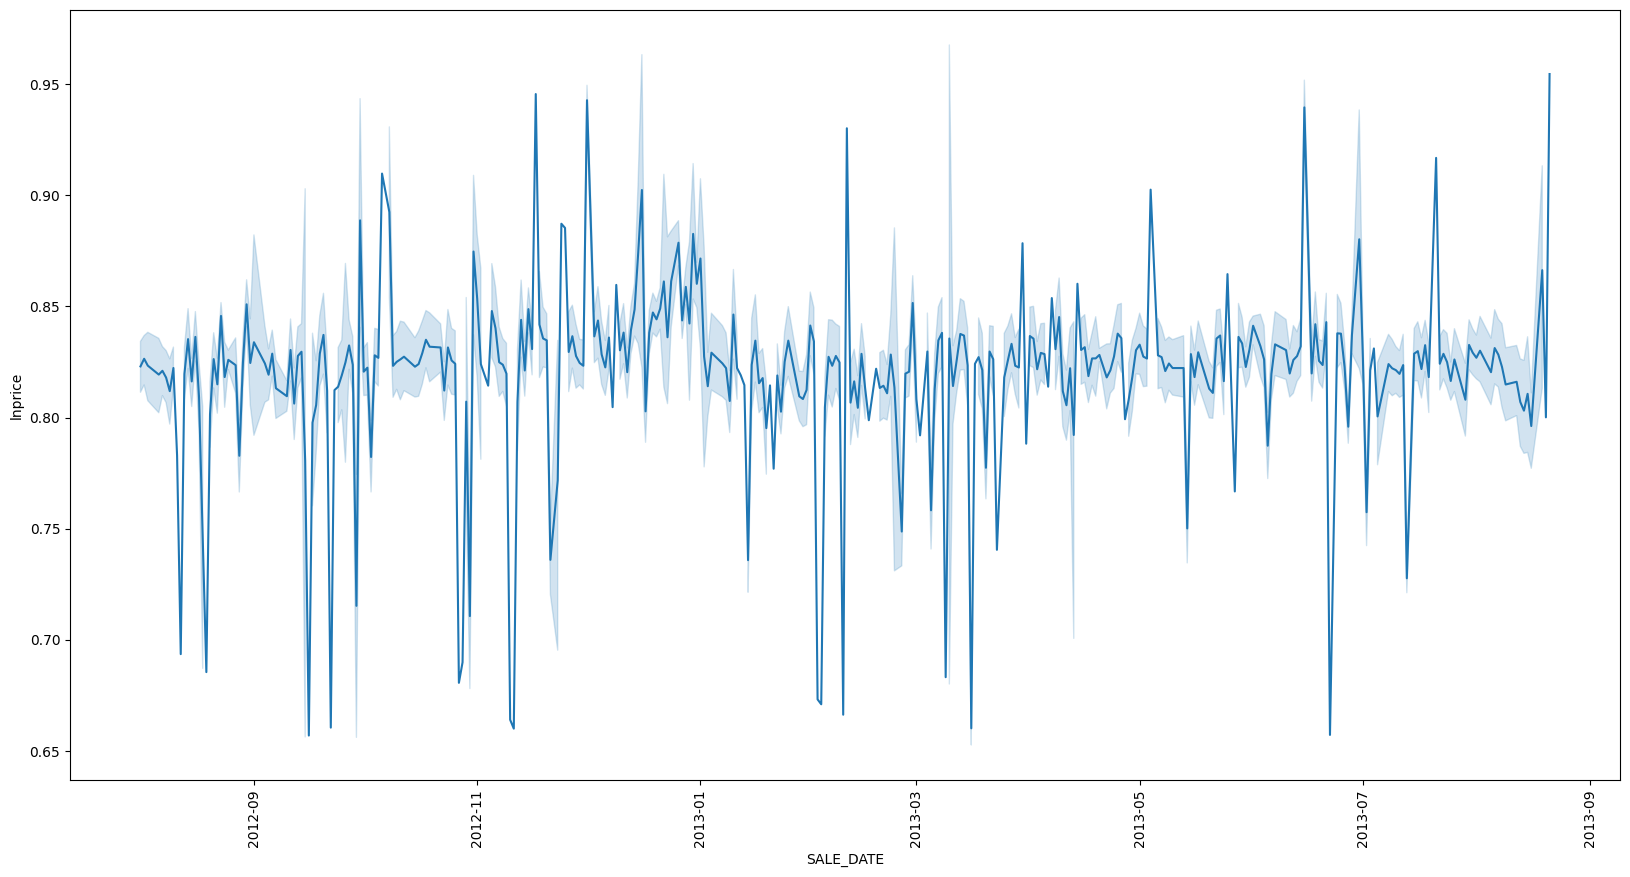

In [105]:
fig, axes=plt.subplots(figsize=[20,10])
sns.lineplot(y="lnprice", x="SALE_DATE", data=dfnorm)
plt.xticks(rotation = 'vertical')
plt.show()


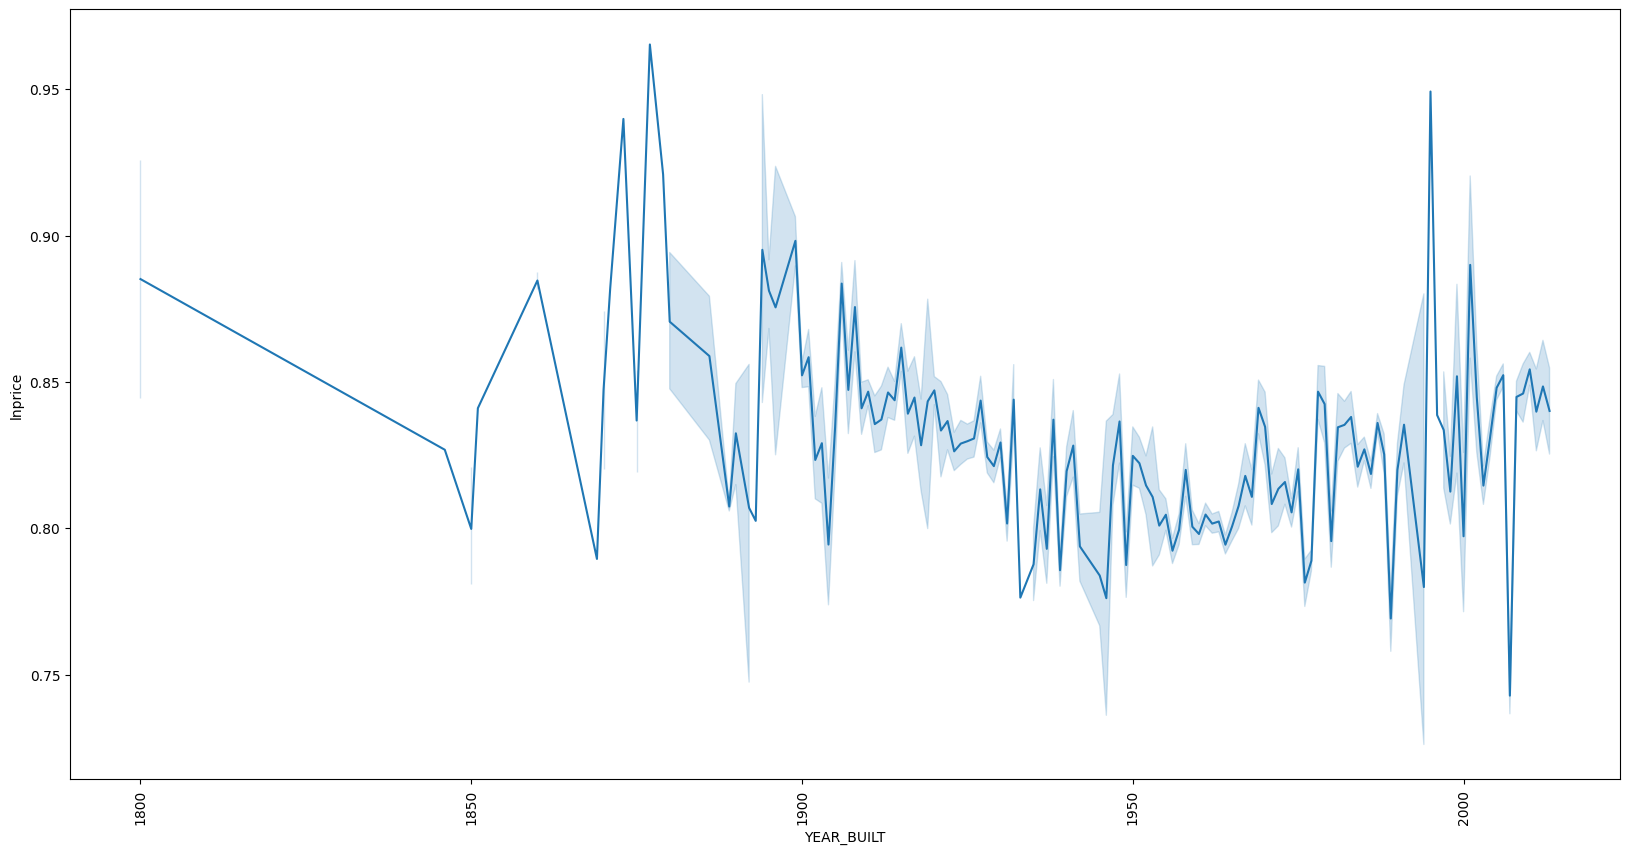

In [106]:
fig, axes=plt.subplots(figsize=[20,10])
sns.lineplot(y="lnprice", x="YEAR_BUILT", data=dfnorm)
plt.xticks(rotation = 'vertical')
plt.show()

C:\Users\zacha\AppData\Local\Temp\ipykernel_2724\2831284990.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  matrix=scatter_matrix(dfnorm, alpha=0.3, diagonal='kde', ax = ax)


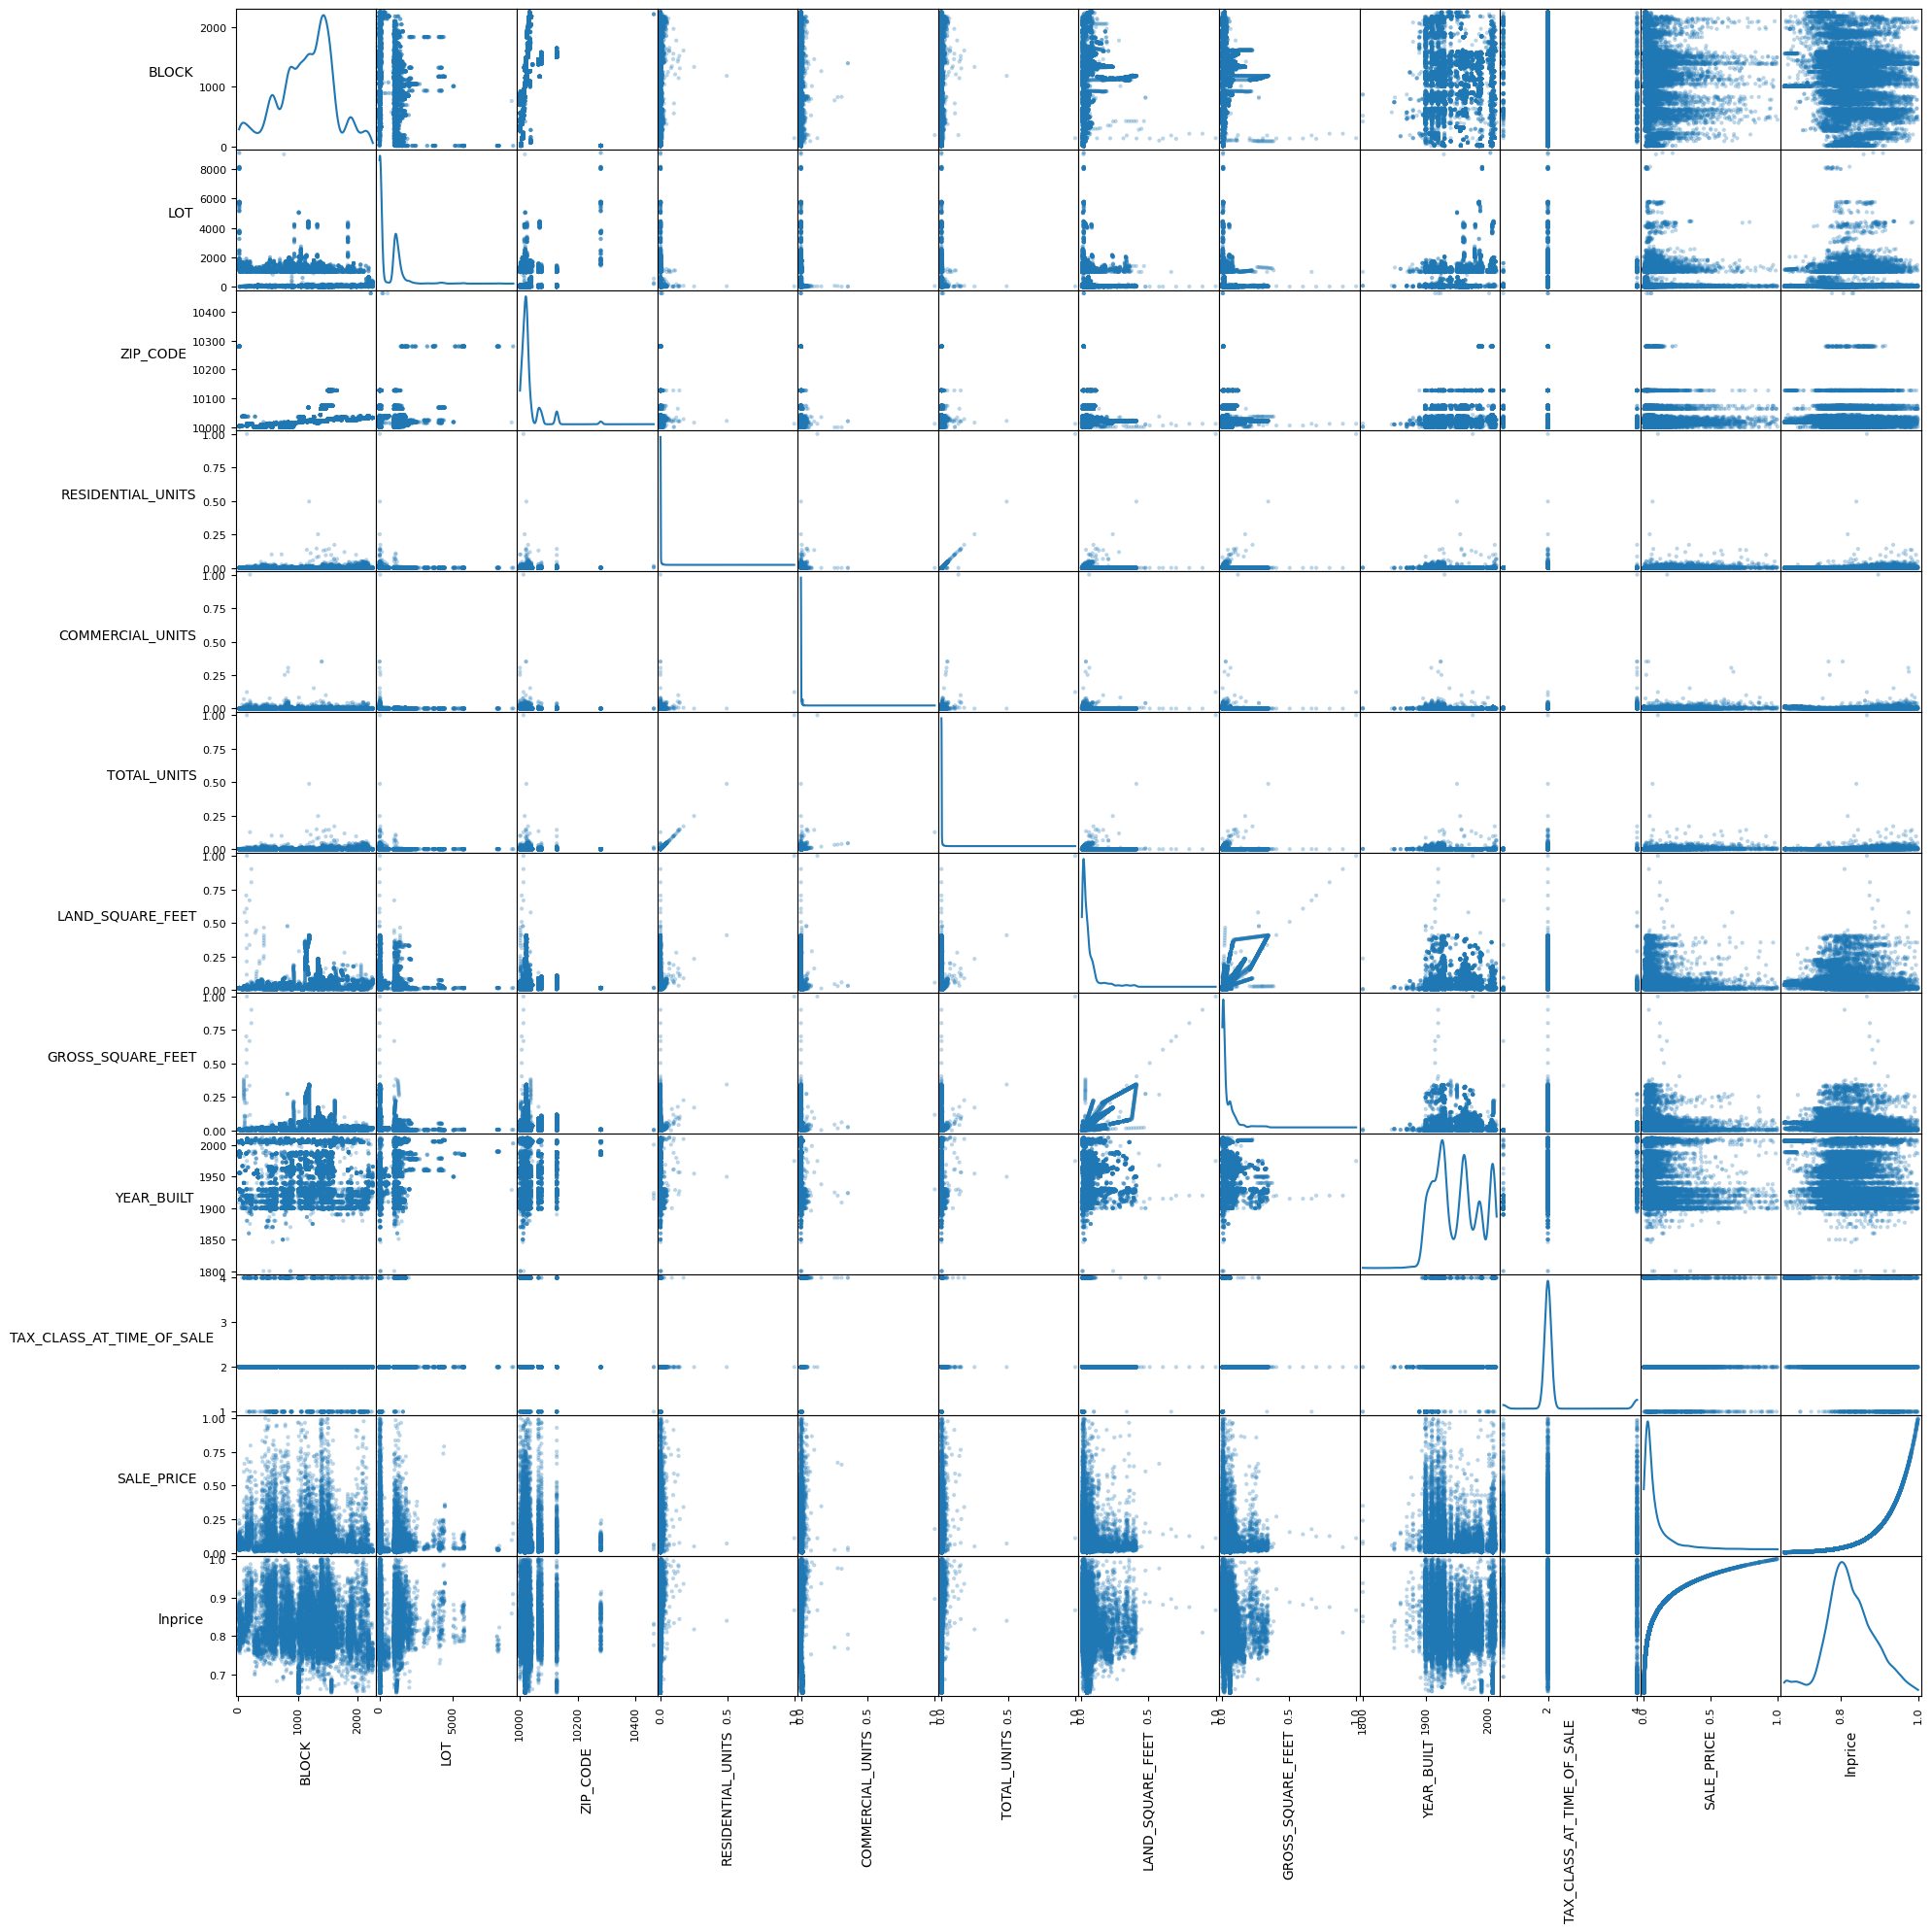

In [107]:
fig = plt.figure(1, figsize=[20, 20])
fig.clf()
ax = fig.gca()
matrix=scatter_matrix(dfnorm, alpha=0.3, diagonal='kde', ax = ax)
for ax in matrix.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


C:\Users\zacha\AppData\Local\Temp\ipykernel_2724\3470296617.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(dfnorm.corr(), vmin=-1, vmax=1, annot=True)


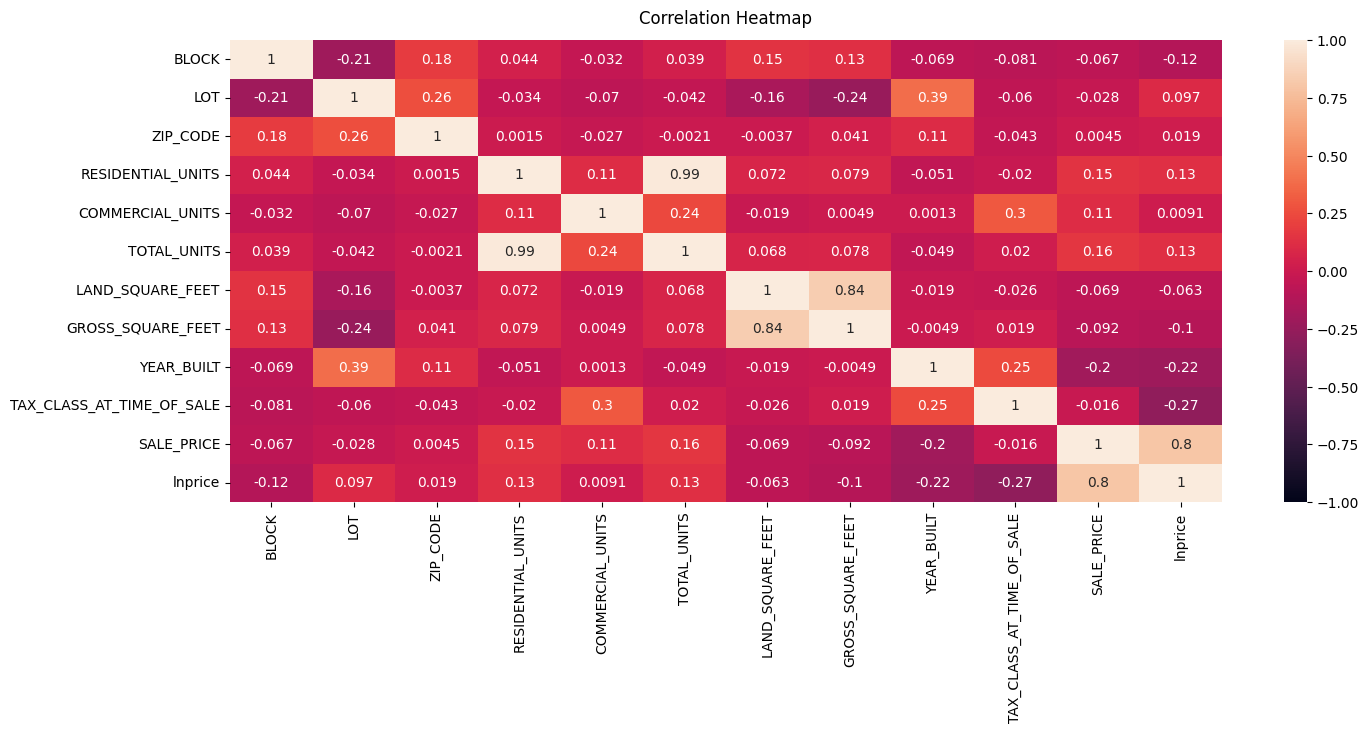

In [108]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfnorm.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [64]:
def regressionFitNumerical(df, column):
    f='lnprice~'+column
    model = smf.ols(formula=f, data=df).fit()
    predicted=model.predict(df[column])
    plt.plot(df[column],df["lnprice"], 'bo')
    plt.plot(df[column], predicted, 'r-', linewidth=2)
    #plt.title('Linear Regression Fit')
    plt.show()
    print('\n',model.params)
    print("confidence interval:\n", model.conf_int(alpha=0.05),'\n')
    print("P values:\n", model.pvalues)
    print("R-Squared", model.rsquared)



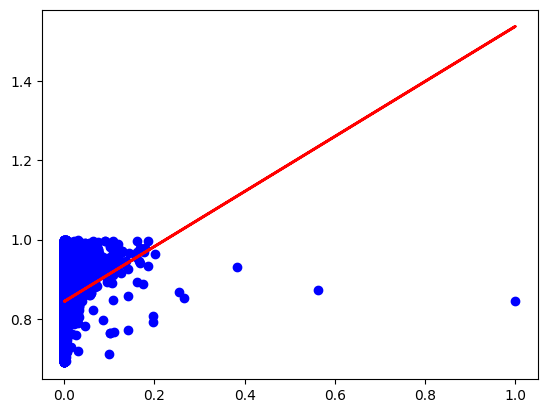


 Intercept            0.843912
RESIDENTIAL_UNITS    0.692798
dtype: float64
confidence interval:
                           0         1
Intercept          0.842983  0.844840
RESIDENTIAL_UNITS  0.634533  0.751064 

P values:
 Intercept             0.000000e+00
RESIDENTIAL_UNITS    6.423901e-118
dtype: float64
R-Squared 0.03720030682747011


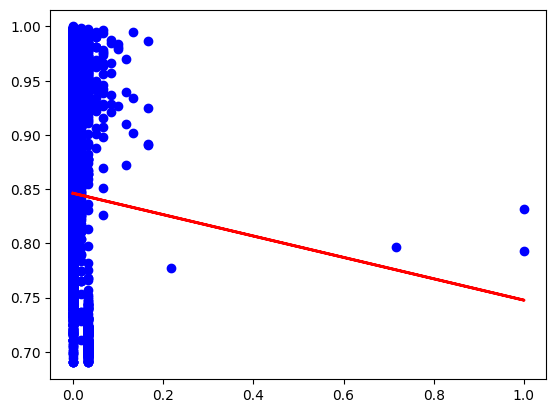


 Intercept           0.846208
COMMERCIAL_UNITS   -0.098576
dtype: float64
confidence interval:
                          0         1
Intercept         0.845274  0.847143
COMMERCIAL_UNITS -0.157357 -0.039795 

P values:
 Intercept           0.000000
COMMERCIAL_UNITS    0.001015
dtype: float64
R-Squared 0.0007679771290258763


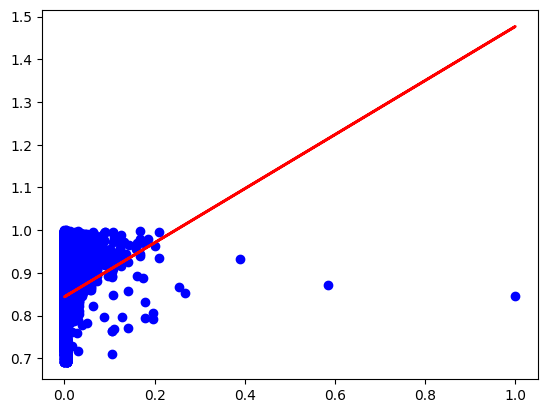


 Intercept      0.843873
TOTAL_UNITS    0.633116
dtype: float64
confidence interval:
                     0         1
Intercept    0.842940  0.844806
TOTAL_UNITS  0.576561  0.689671 

P values:
 Intercept       0.000000e+00
TOTAL_UNITS    5.756368e-105
dtype: float64
R-Squared 0.033114751426679634


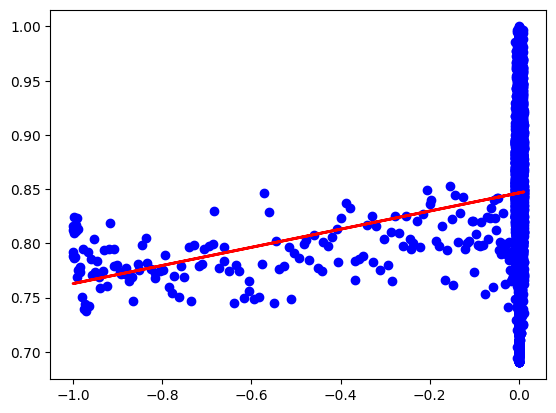


 Intercept           0.846543
LAND_SQUARE_FEET    0.083642
dtype: float64
confidence interval:
                          0         1
Intercept         0.845616  0.847471
LAND_SQUARE_FEET  0.070474  0.096811 

P values:
 Intercept           0.000000e+00
LAND_SQUARE_FEET    2.142366e-35
dtype: float64
R-Squared 0.010905340381488493


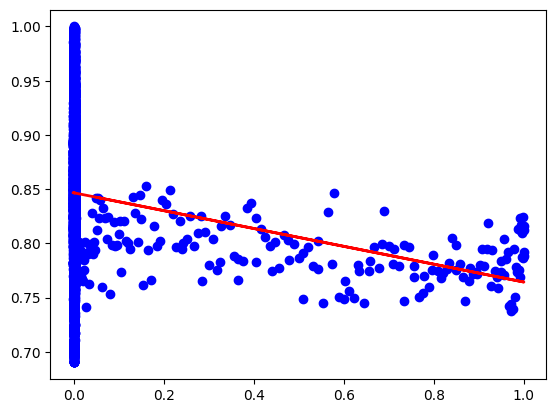


 Intercept            0.846589
GROSS_SQUARE_FEET   -0.082251
dtype: float64
confidence interval:
                           0         1
Intercept          0.845661  0.847517
GROSS_SQUARE_FEET -0.095406 -0.069096 

P values:
 Intercept            0.000000e+00
GROSS_SQUARE_FEET    2.355361e-34
dtype: float64
R-Squared 0.010570127186946277


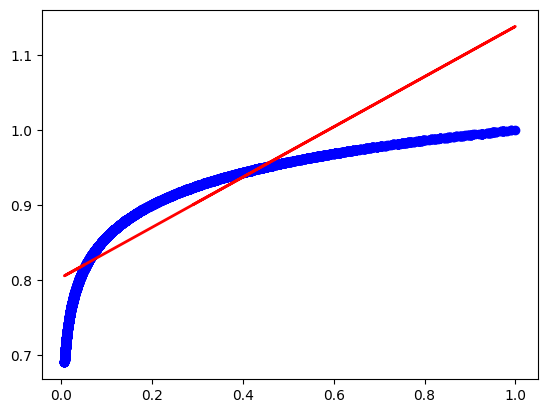


 Intercept     0.803431
SALE_PRICE    0.334406
dtype: float64
confidence interval:
                    0         1
Intercept   0.802781  0.804080
SALE_PRICE  0.331018  0.337795 

P values:
 Intercept     0.0
SALE_PRICE    0.0
dtype: float64
R-Squared 0.7269077174118175


PatsyError: Error evaluating factor: NameError: name 'SALE_PRICE_CATEGORY' is not defined
    lnprice~SALE_PRICE_CATEGORY
            ^^^^^^^^^^^^^^^^^^^

In [121]:
#numerical.remove("SALE_PRICE")
numerical.append("SALE_PRICE_CATEGORY")
for col in numerical:
    if col=="lnprice":
        continue

    regressionFitNumerical(dfnorm, col)



Root Mean Squared Error: 0.05
Cross-validation scores:  [ 1.16802429e-01  2.20230448e-02  1.45313274e-01 -1.70738938e-01
 -6.31305368e+01]
Mean cross-validation score: -12.60
Y-axis intercept 0.7990
Weight coefficients:
    RESIDENTIAL_UNITS: -0.4502
     COMMERCIAL_UNITS: -0.3084
          TOTAL_UNITS: 1.0476
     LAND_SQUARE_FEET: 0.3750
    GROSS_SQUARE_FEET: 0.3246
 AVG_SALE_PRICE_CATEGORY: 0.0230
R squared for the training data is 0.139
Score against test data: 0.150


<AxesSubplot: xlabel='lnprice', ylabel='Count'>

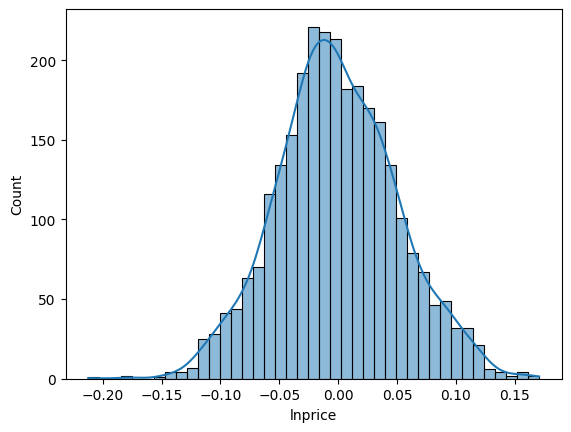

In [122]:

# select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
#         'GROSS_SQUARE_FEET', 'NEIGHBORHOOD']
# # Select predictors
# X = dfnorm[select_features]

# # Encode categorical variables using one-hot encoding
# X = pd.get_dummies(X)

# # Target variable
# Y = dfnorm['lnprice']
# trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
# lm = linear_model.LinearRegression()
# lm.fit(trainX, trainY)
# print("Y-axis intercept {:6.4f}".format(lm.intercept_))
# print("Weight coefficients:")
# for feat, coef in zip(select_features, lm.coef_):
#     print(" {:>20}: {:6.4f}".format(feat, coef))
# # The value of R^2
# print("R squared for the training data is {:4.3f}".format(lm.score(trainX,
# trainY)))
# print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'AVG_SALE_PRICE_CATEGORY']
# Select predictors
X = dfnorm[select_features]

# Encode categorical variables using one-hot encoding
#X = pd.get_dummies(X)

# Target variable
dfnorm.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = dfnorm['lnprice']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Y-axis intercept {:6.4f}".format(model.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, model.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train,
y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

# Plot histogram of residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)

In [28]:
def mse(df, pred, obs):
    n = df.shape[0]
    return sum((df[pred]-df[obs])**2)/n
dfnorm['pred'] = model.predict(X)
print("Mean Squared error: {}".format(mse(dfnorm,'pred', 'lnprice')))

Mean Squared error: 0.0026739352450832156


Score against test data: 0.192


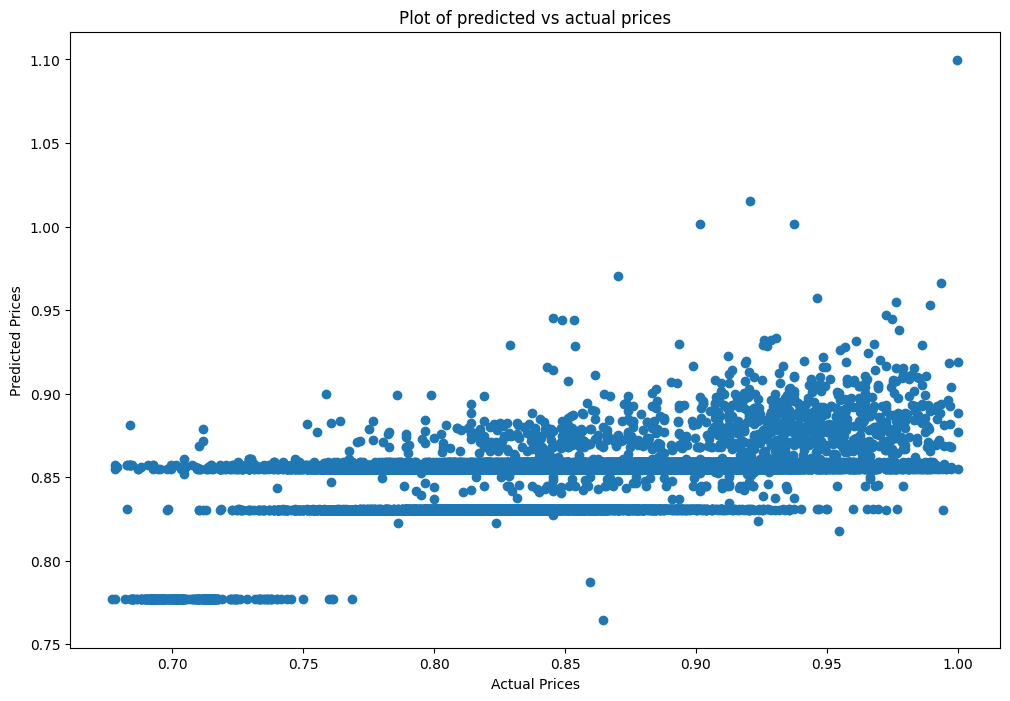

In [103]:

rbf = svm.SVR(kernel="rbf", C=1e2, tol=1e-4)
rbf.fit(X_train, y_train)
print("Score against test data: {:4.3f}".format(rbf.score(X_test, y_test)))

# Make predictions with SVM model
dfnorm_X = dfnorm[select_features]
#dfnorm_X = scaler.transform(dfnorm_X)
predicted = rbf.predict(dfnorm_X)

# Plot predicted vs actual prices
plt.figure(figsize=(12, 8))
plt.scatter(dfnorm['lnprice'], predicted)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Plot of predicted vs actual prices")
plt.show()

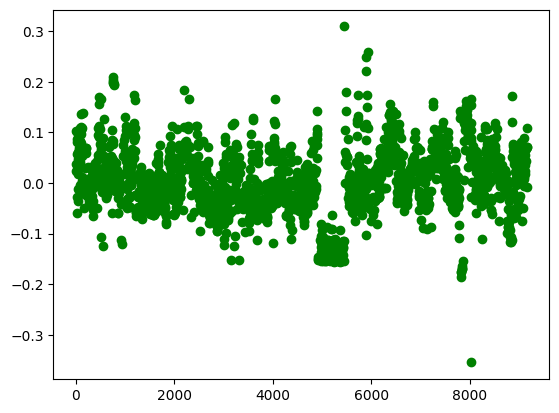

In [91]:
pred=model.predict(X_test)
res=(y_test-pred)
plt.plot(res, 'go')
plt.show()

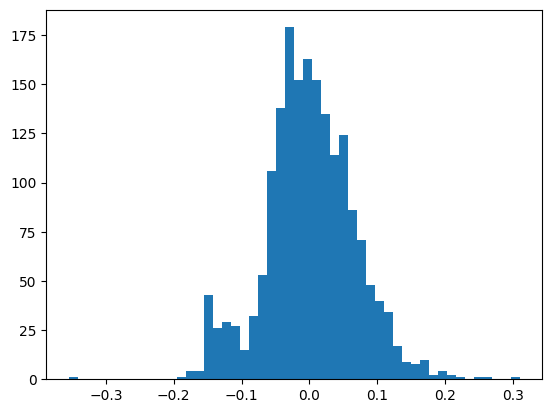

In [92]:
plt.hist(res, bins=50)
plt.show()

In [264]:
RSEd = ((y_test-pred)**2).sum()
RSE = np.sqrt(RSEd/(dfnorm.shape[0]-1-1))
RSE

0.031935264253005614

In [68]:
x=dfnorm[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE_CATEGORY']]
y=dfnorm['lnprice']
model=sm.OLS(y,x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                lnprice   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              6514.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        10:56:32   Log-Likelihood:                         -1359.9
No. Observations:                5930   AIC:                                      2732.
Df Residuals:                    5924   BIC:                                      2772.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [ ]:
def convertNeighborhood(df):
#     m = np.zeros(df.shape[0])
#     dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()
    
#     n=np.zeros(dfgroup.shape[0])
#     for i, r in dfgroup.iterrows():
#         if r["SALE_PRICE"]<.12:
#             n[i]=1
#         elif r["SALE_PRICE"]>.15:
#             n[i]=3
#         else:
#             n[i]=2
#     dfgroup['NCat']=n
#     for i, r in df.iterrows():
#         temp = dfgroup[dfgroup["NEIGHBORHOOD"]==r["NEIGHBORHOOD"]]["NCat"]
#         m[i]=temp

#     return m